In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import torch 
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils 
import PIL.Image as img
import random as rd
import time

In [2]:
transform=transforms.Compose([     
                                   transforms.Scale(32),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])

In [3]:
transfer_dem_data = torchvision.datasets.ImageFolder(root='./data/DEM-300m-normed-test-florence/',transform=transform)
transfer_data_loader = torch.utils.data.DataLoader(transfer_dem_data,
                                          batch_size=64,
                                          shuffle=True)
base_dem_data=torchvision.datasets.ImageFolder(root='./data/DEM-300m-normed/',transform=transform)
base_data_loader = torch.utils.data.DataLoader(base_dem_data,
                                          batch_size=64,
                                          shuffle=True,drop_last=True)

In [4]:
def my_imshow(img):
    fig,ax=plt.subplots(nrows=8,ncols=8,figsize=(8,8),sharex=True,sharey=True)
    for i in range(0,64):
        ax[i/8,i%8].imshow(img[i].numpy()/2+0.5,cmap=plt.cm.gray)
        ax[i/8,i%8].axis('off')
    fig.set_tight_layout(True)

In [5]:
transfer_dataiter=iter(transfer_data_loader)
base_dataiter=iter(base_data_loader)

# 迁移数据

In [6]:
transfer_dataiter.next()[0][:,0,:,:]


(0 ,.,.) = 
 -0.9373 -0.9294 -0.9216  ...  -0.7412 -0.7098 -0.6941
 -0.9373 -0.9373 -0.9216  ...  -0.7569 -0.7176 -0.7255
 -0.9294 -0.9294 -0.9294  ...  -0.7725 -0.7569 -0.7725
           ...             ⋱             ...          
 -0.9608 -0.9529 -0.9529  ...  -0.8980 -0.8824 -0.8667
 -0.9686 -0.9686 -0.9608  ...  -0.8902 -0.8824 -0.8667
 -0.9686 -0.9686 -0.9686  ...  -0.8980 -0.8824 -0.8588

(1 ,.,.) = 
 -0.8667 -0.8745 -0.8824  ...  -0.8431 -0.8510 -0.8588
 -0.8588 -0.8667 -0.8824  ...  -0.8353 -0.8431 -0.8510
 -0.8667 -0.8745 -0.8745  ...  -0.8431 -0.8431 -0.8510
           ...             ⋱             ...          
 -0.9765 -0.9765 -0.9765  ...  -0.9294 -0.9373 -0.9529
 -0.9843 -0.9765 -0.9765  ...  -0.9216 -0.9294 -0.9373
 -0.9843 -0.9843 -0.9843  ...  -0.9137 -0.9216 -0.9294

(2 ,.,.) = 
 -0.9686 -0.9608 -0.9608  ...  -0.9686 -0.9765 -0.9765
 -0.9608 -0.9608 -0.9608  ...  -0.9608 -0.9686 -0.9686
 -0.9608 -0.9686 -0.9608  ...  -0.9608 -0.9608 -0.9686
           ...            

In [7]:
# 读取Florence的地形数据images
images=transfer_dataiter.next()[0]
florence_dems=torch.FloatTensor(images.size(0),1,images.size(2),images.size(3))
florence_dems=Variable(florence_dems)
florence_dems=florence_dems.cuda()
florence_dems.data.copy_(images[:,0,:,:])

/home/patrick/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  



(0 ,0 ,.,.) = 
 -0.7882 -0.7725 -0.7490  ...  -0.6941 -0.7098 -0.7255
 -0.7804 -0.7647 -0.7490  ...  -0.7098 -0.7176 -0.7255
 -0.7725 -0.7569 -0.7569  ...  -0.7176 -0.7333 -0.7490
           ...             ⋱             ...          
 -0.9059 -0.8902 -0.8824  ...  -0.8745 -0.8824 -0.8902
 -0.9059 -0.8980 -0.8902  ...  -0.8902 -0.8902 -0.8824
 -0.9059 -0.9059 -0.8980  ...  -0.8902 -0.8824 -0.8745
     ⋮ 

(1 ,0 ,.,.) = 
 -0.8667 -0.8824 -0.8902  ...  -0.8902 -0.8902 -0.8902
 -0.8745 -0.8824 -0.8980  ...  -0.9137 -0.9137 -0.9137
 -0.8902 -0.8902 -0.8902  ...  -0.8824 -0.8980 -0.9137
           ...             ⋱             ...          
 -0.8902 -0.8902 -0.8902  ...  -0.8902 -0.8980 -0.9059
 -0.8980 -0.8980 -0.8980  ...  -0.9059 -0.9137 -0.9059
 -0.9059 -0.9059 -0.9059  ...  -0.9059 -0.9216 -0.9216
     ⋮ 

(2 ,0 ,.,.) = 
 -0.9216 -0.9137 -0.9216  ...  -0.9216 -0.9216 -0.9216
 -0.9216 -0.9216 -0.9137  ...  -0.9216 -0.9216 -0.9216
 -0.9294 -0.9294 -0.9216  ...  -0.9216 -0.9216 -0.9216
 

In [8]:
nc=1
ncp=36
imageSize=32
batch_s=64
L_ele=-7
H_ele=6999
pathnetG='./cdcgan-dem-E-D/outfile_'+str(ncp)+'_samples/nets/netG_epoch_200.pth'

def ControlPointsImage(dems,ncp):
    y_cpLayer = torch.FloatTensor(batch_s,nc,imageSize,imageSize).zero_()
    y_cpLayer = Variable(y_cpLayer)
    y_cpLayer = y_cpLayer.cuda()
    cp=[]
    x_index=[]
    y_index=[]
    step=float((imageSize-1)/(np.sqrt(ncp)-1))
    #print step
    for i in range(0,int(np.floor(np.sqrt(ncp)))):
        x_index.append(i*step)
        y_index.append(i*step)
    for n in range(0,batch_s):
        cp.append([])
        for i in x_index:
            for j in y_index:
                cp[n].append([dems[n,0,int(round(i)),int(round(j))],int(round(i)),int(round(j))])# extract dem control point function
    for i in range(0,batch_s): 
        for _cp in cp[i]:
            h=_cp[0]
            x=_cp[1]
            y=_cp[2]
            y_cpLayer[i,0,x,y]=h
    return y_cpLayer
class Generator(nn.Module):
    def __init__(self, nc, ngf):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(nc,ngf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 16 x 16 x 64
        self.layer2 = nn.Sequential(nn.Conv2d(ngf,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 8 x 8 x 128
        
        self.layer3 = nn.Sequential(nn.Conv2d(ngf*2,ngf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*4),
                                 nn.LeakyReLU(0.2,inplace=True))
        # 4 x 4 x 256                     
        # 4 x 4 x 256
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(ngf*4,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.ReLU())
        # 8 x 8 x 128
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(ngf*2,ngf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf),
                                 nn.ReLU())
        # 16 x 16 x 64
        self.layer6 = nn.Sequential(nn.ConvTranspose2d(ngf,nc,kernel_size=4,stride=2,padding=1),
                                 nn.Tanh())
        # 32 x 32 x 1
    def forward(self,_cpLayer):
        out = self.layer1(_cpLayer)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        return out

1.42474603653


/home/patrick/anaconda2/envs/deeplearning/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


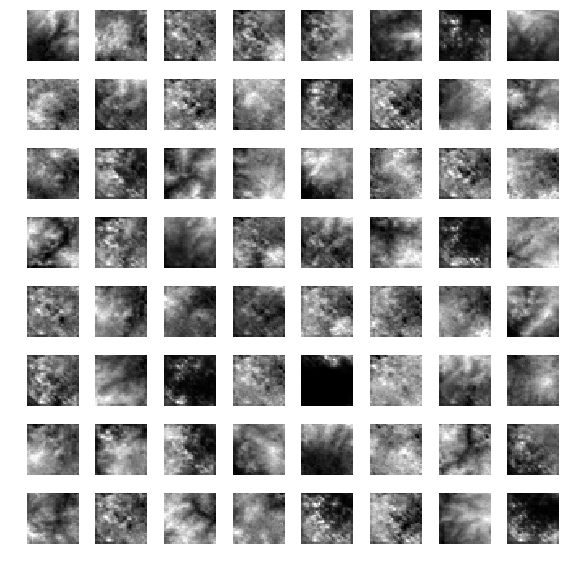

In [9]:
#Pre-trained 插值
netG = Generator(nc, 64)
netG.load_state_dict(torch.load(pathnetG))
netG.cuda()
cpLayer=ControlPointsImage(florence_dems,ncp)
t1=time.time()
fake_florence_dems = netG(cpLayer)
t2=time.time()
print t2-t1
# vutils.save_image(fake.data,'./pics/cedgan_'+str(ncp)+'.png',normalize=True)
my_imshow(fake_florence_dems.cpu().data[:,0,:,:])
# vutils.save_image(fake.data[0,0,:,:],'./pics/featuremaps/input.png',normalize=True)

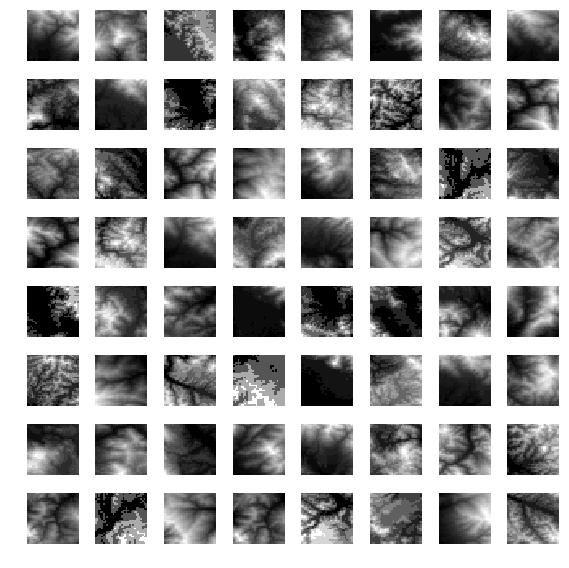

In [10]:
my_imshow(florence_dems.cpu().data[:,0,:,:])

In [11]:
criterion = nn.MSELoss(size_average=True)

mdems = torch.FloatTensor(batch_s, nc, imageSize, imageSize) # real data with meter scale
mdems = Variable(mdems)
mdems=mdems.cuda()

mdems.data.copy_(florence_dems.data)
mdems.data.copy_(L_ele+(mdems.data/2+0.5)*(H_ele-L_ele))
fake_florence_dems.data.copy_(L_ele+(fake_florence_dems.data/2+0.5)*(H_ele-L_ele))
errG = criterion(fake_florence_dems,mdems)
print ('Gerror: %f'% (np.sqrt(errG.data[0]/1024)))
print 'ncp='+str(ncp)

Gerror: 10.034148
ncp=36


In [55]:
def my_selected_imshow(img,list_id):
    fig,ax=plt.subplots(nrows=1,ncols=len(list_id),figsize=(len(list_id)*2,2),sharex=True,sharey=True)
    count=0
    for i in list_id:
        ax[count].imshow(img[i].numpy()/2+0.5,cmap=plt.cm.gray)
        ax[count].axis('off')
        count+=1
    fig.set_tight_layout(True)

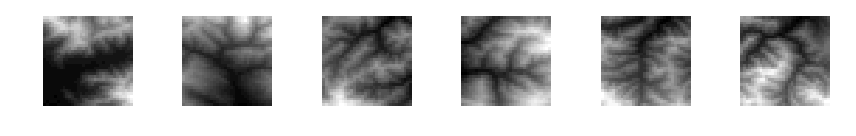

In [386]:
my_selected_imshow(florence_dems.cpu().data[:,0,:,:],[8,14,15,19,36,37])

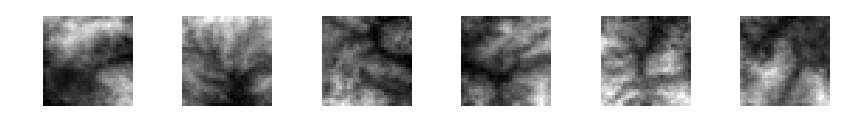

In [387]:
my_selected_imshow(fake_florence_dems.cpu().data[:,0,:,:],[8,14,15,19,36,37])

# Feature map visualization

In [12]:
# 读取训练集一个batch
training_images=base_dataiter.next()[0]
training_dems=torch.FloatTensor(training_images.size(0),1,training_images.size(2),training_images.size(3))
training_dems=Variable(training_dems)
training_dems=training_dems.cuda()
training_dems.data.copy_(training_images[:,0,:,:])

/home/patrick/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  import sys



(0 ,0 ,.,.) = 
 -0.8588 -0.8588 -0.8588  ...  -0.8667 -0.8667 -0.8667
 -0.8588 -0.8588 -0.8588  ...  -0.8667 -0.8667 -0.8667
 -0.8588 -0.8588 -0.8588  ...  -0.8667 -0.8667 -0.8667
           ...             ⋱             ...          
 -0.8588 -0.8588 -0.8588  ...  -0.8588 -0.8588 -0.8588
 -0.8588 -0.8588 -0.8588  ...  -0.8588 -0.8588 -0.8510
 -0.8588 -0.8510 -0.8510  ...  -0.8588 -0.8510 -0.8510
     ⋮ 

(1 ,0 ,.,.) = 
 -0.4275 -0.4667 -0.4980  ...  -0.4431 -0.4353 -0.4431
 -0.4353 -0.4745 -0.5216  ...  -0.4667 -0.4588 -0.4667
 -0.4745 -0.5059 -0.5451  ...  -0.4588 -0.4902 -0.4824
           ...             ⋱             ...          
 -0.5765 -0.5843 -0.5765  ...  -0.5059 -0.5373 -0.5529
 -0.5608 -0.5843 -0.6000  ...  -0.5059 -0.5686 -0.5765
 -0.5294 -0.5686 -0.5843  ...  -0.5137 -0.5529 -0.5922
     ⋮ 

(2 ,0 ,.,.) = 
 -0.2706 -0.3255 -0.3804  ...  -0.5137 -0.5294 -0.5059
 -0.3020 -0.3490 -0.3882  ...  -0.5529 -0.5216 -0.4745
 -0.3255 -0.3804 -0.4275  ...  -0.5451 -0.5059 -0.4667
 

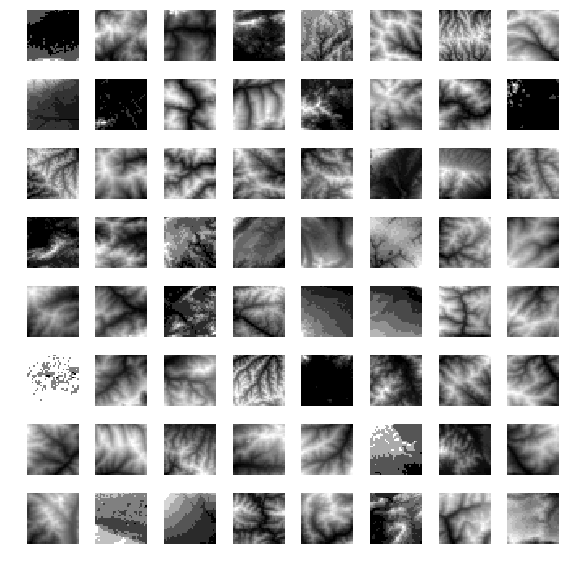

In [13]:
my_imshow(training_dems.cpu().data[:,0,:,:])

In [84]:
# ncp=36, epoch=200
ncp=100
pathnetG='./cdcgan-dem-E-D/outfile_'+str(ncp)+'_samples/nets/netG_epoch_200.pth'

netGG = Generator(nc, 64)
netGG.load_state_dict(torch.load(pathnetG))
netGG.cuda()
cpLayer=ControlPointsImage(training_dems,ncp)
l1=netGG.layer1(cpLayer)
# print l1
l2=netGG.layer2(l1)
# print l2
l3=netGG.layer3(l2)
l4=netGG.layer4(l3)
l5=netGG.layer5(l4)
l6=netGG.layer6(l5)
# print l3.data[:,:,:,:]

In [85]:
print l1.data.shape,l2.data.shape,l3.data.shape,l4.data.shape,l5.data.shape,l6.data.shape

torch.Size([64, 64, 16, 16]) torch.Size([64, 128, 8, 8]) torch.Size([64, 256, 4, 4]) torch.Size([64, 128, 8, 8]) torch.Size([64, 64, 16, 16]) torch.Size([64, 1, 32, 32])


In [132]:
def my_imshow_featuremap(img):
    fig,ax=plt.subplots(nrows=8,ncols=8,figsize=(8,8),sharex=True,sharey=True)
    for i in range(0,64):
        ax[i/8,i%8].imshow(img[i].numpy()/2+0.5,cmap=plt.cm.YlGnBu)
        ax[i/8,i%8].axis('off')
    fig.set_tight_layout(True)
def my_selected_imshow_featuremap(img,list_id):
    fig,ax=plt.subplots(nrows=1,ncols=len(list_id),figsize=(len(list_id)*2,2),sharex=True,sharey=True)
    count=0
    for i in list_id:
        ax[count].imshow(img[i].numpy()/2+0.5,cmap=plt.cm.YlGnBu)
        ax[count].axis('off')
        count+=1
    fig.set_tight_layout(True)

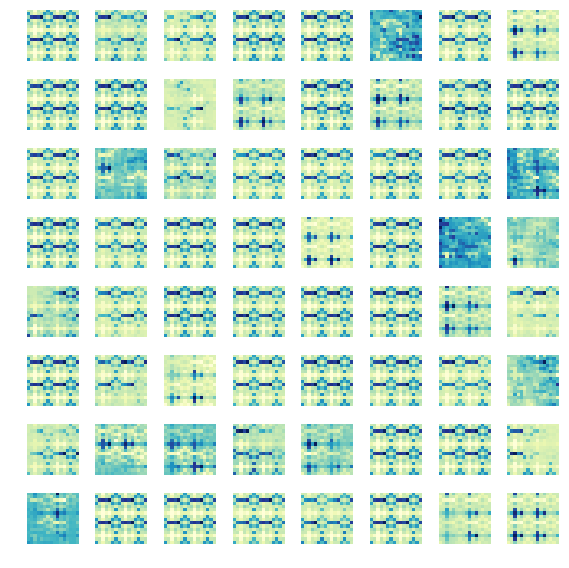

In [133]:
my_imshow_featuremap(l1.cpu().data[:,58,:,:])

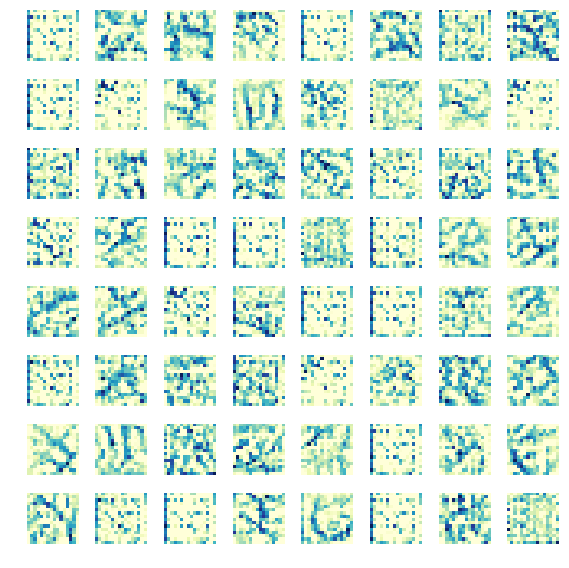

In [134]:
#my_imshow_featuremap(l5.cpu().data[2,:,:,:])#可以判断第几个featuremap是更容易理解的
my_imshow_featuremap(l5.cpu().data[:,58,:,:])

# ncp=36 prominentfm=3; ncp=100 prominentfm=58 此处为100的

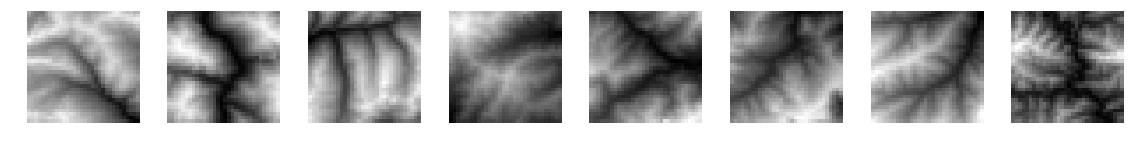

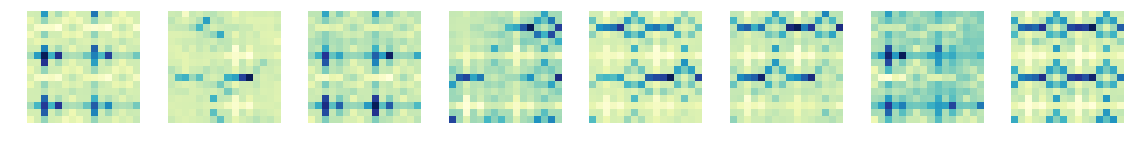

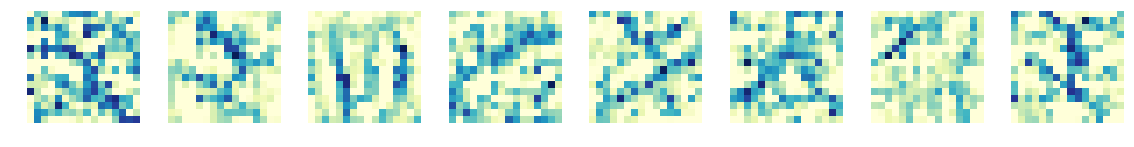

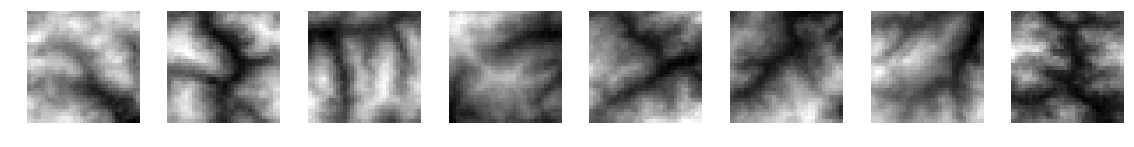

In [135]:
selected_list=[7,10,11,32,33,41,52,59] 
my_selected_imshow(training_dems.cpu().data[:,0,:,:],selected_list)
my_selected_imshow_featuremap(l1.cpu().data[:,58,:,:],selected_list)
my_selected_imshow_featuremap(l5.cpu().data[:,58,:,:],selected_list)
my_selected_imshow(l6.cpu().data[:,0,:,:],selected_list)

In [112]:
def plot_cmap(cmap, ncolor):
    """ 
    A convenient function to plot colors of a matplotlib cmap
 
    Args:
        ncolor (int): number of color to show
        cmap: a cmap object or a matplotlib color name
    """
 
    if isinstance(cmap, str):
        try:
            cm = plt.get_cmap(cmap)
        except ValueError:
            print("WARNINGS :", cmap, " is not a known colormap")
            cm = plt.cm.gray
    else:
        cm = cmap
 
    with plt.rc_context(plt.rcParamsDefault):
        fig = plt.figure(figsize=(6, 1), frameon=False)
        ax = fig.add_subplot(111)
        ax.pcolor(np.linspace(1, ncolor, ncolor).reshape(1, ncolor), cmap=cm)
        ax.set_title(cm.name)
        xt = ax.set_xticks([])
        yt = ax.set_yticks([])
    return fig

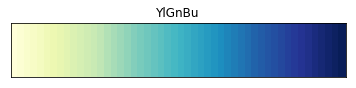

In [123]:
fig = plot_cmap(plt.cm.YlGnBu, 50)

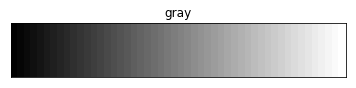

In [115]:
fig = plot_cmap(plt.cm.gray, 50)

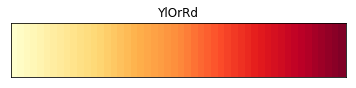

In [137]:
fig = plot_cmap(plt.cm.YlOrRd, 50)

In [ ]:
# vutils.save_image(l1.data[0,i,:,:],'./pics/featuremaps/l1_'+str(i)+'.png',normalize=True)

# for i in range(0,64):
# #     imshow(torchvision.utils.make_grid(l1.data[0,5,:,:]))#image_id,feature_channel,x,y
#     vutils.save_image(l1.data[0,i,:,:],'./pics/featuremaps/l1_'+str(i)+'.png',normalize=True)
# for i in range(0,128):
# #     imshow(torchvision.utils.make_grid(l1.data[0,5,:,:]))#image_id,feature_channel,x,y
#     vutils.save_image(l2.data[0,i,:,:],'./pics/featuremaps/l2_'+str(i)+'.png',normalize=True)
# for i in range(0,256):
# #     imshow(torchvision.utils.make_grid(l1.data[0,5,:,:]))#image_id,feature_channel,x,y
#     vutils.save_image(l3.data[0,i,:,:],'./pics/featuremaps/l3_'+str(i)+'.png',normalize=True)
# for i in range(0,128):
# #     imshow(torchvision.utils.make_grid(l1.data[0,5,:,:]))#image_id,feature_channel,x,y
#     vutils.save_image(l4.data[0,i,:,:],'./pics/featuremaps/l4_'+str(i)+'.png',normalize=True)
# for i in range(0,64):
# #     imshow(torchvision.utils.make_grid(l1.data[0,5,:,:]))#image_id,feature_channel,x,y
#     vutils.save_image(l5.data[0,i,:,:],'./pics/featuremaps/l5_'+str(i)+'.png',normalize=True)
# for i in range(0,1):
# #     imshow(torchvision.utils.make_grid(l1.data[0,5,:,:]))#image_id,feature_channel,x,y
#     vutils.save_image(l6.data[0,i,:,:],'./pics/featuremaps/l6_'+str(i)+'.png',normalize=True)

# cpLayer=ControlPointsImage(dems,ncp)
# t1=time.time()
# fake = netG(cpLayer)
# t2=time.time()